# Feature Importance
#### Author: Arman Tavana

In this notebook we will cover different methods to find the importance of each feature in our model.

Methods covered in this notebook:
1. Spearman's rank correlation
2. PCA
3. Permutation Importance
4. Drop Column Importance
5. Shap (SHapley Additive exPlanations)
6. Comparing strategies
7. Automatic feature selection algorithm
8. Variance and empirical p-values for feature importances
    - Variance
    - empirical p-values

In [1]:
from featimp import *

In [2]:
%run featimp

In [4]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

Adding a column filled with random number so we could see our feature importance methods are working properly or not.

In [5]:
X = df.drop('target', axis=1)
X['random'] = np.random.random(size=len(X))
y = df['target']

In [6]:
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


### Spearman's rank correlation

- This is a method that finds importance directly from the data.
- Spearman's rank correlation is used to find relationship between different varibales. So, it is one of the simplest ways to find feature importance by seeing how strong the relationship between target variable is with all of the existing features.
- The feature with the largest coefficient is the most important feature.
- Spearman's rank correlation is basically the pearson correlation but it is applied to the rank variables. Here is the formula:
    - $r_s = \rho_{({rg}_X, {rg}_Y)} = {cov({rg}_X, {rg}_Y)}\div {\sigma}_{rgX}{\sigma}_{rgY}$ 


#### Pros:
1. It is the simplest method for feature importance.
2. Does not assume linear relationship or normal distribution.
3. It works very well for independent features.

#### Cons:
1. It does not do well for feaures that are codependent.
2. It does not work with categorical variables.
3. If there are features that are similar it is going to rank the all high even though only one of them should be rank high.

In [7]:
feat_spear = my_spearman(X, y)

Let's visualize how Spearman's rank correlation ranks our features from the boston dataset.

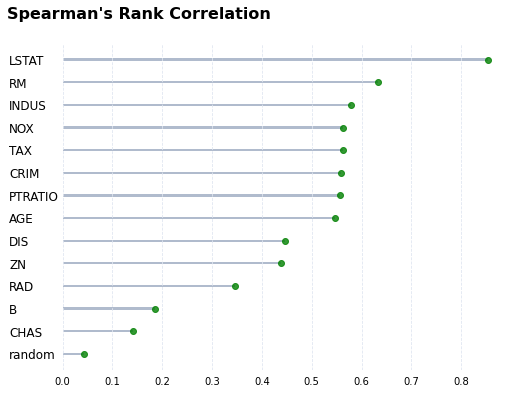

In [8]:
cols_spear, feat_spear_sorted = my_sort(X.columns, feat_spear)
my_plt(feat_spear_sorted, cols_spear,"Spearman's Rank Correlation", -0.111)

After plotting we can observe that the random feature ranked last which is a sign that Spearman's rank does well to find the importance of independent features.

### PCA

- Principle component analysis only takes the columns in X which are just the features.
- This is a method that finds importance directly from the data.
- PCA is an orthogonal transformation that transforms a set of data into a set of uncorrelated data that are in a new space.
- We find the eigenvector with the largest eigenvalue which is the first principle component. That eigenvector would tell us how important the features are by ranking them based on how much they explain variance in the new space
- So, PCA determines importance by how well features do with variance.

#### Pros:
1. Deals with features that are correlated among each other.

#### Cons:
1. It does not work well with categorical variables.
2. It is limited to linear relationships.
3. Also if a variable does best in terms of explaining variance, it does not necessarily mean that it is the most important feature.

In [9]:
feat_pca = pca(X)

Let's visualize what the result looks like using PCA for feature importance.

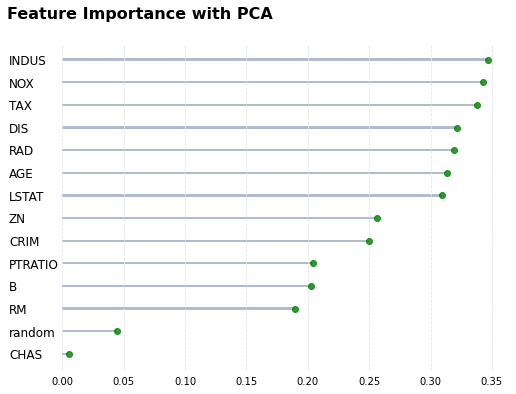

In [10]:
cols_pca, feat_pca_sorted = my_sort(X.columns, feat_pca)
my_plt(feat_pca_sorted, cols_pca,"Feature Importance with PCA", -.045)

We can see that the column with random numbers does poor in the ranking since bunch of random numbers cannot explain variance well in the data.

### Permutation Importance

In permutation importance we start by getting a baseline validation metric (r2, accuracy score, or, ...) by using the data on a pre trained model. Then we go through each column one by one and permute one column at each iteration and then get the new metric using our model on the new data (with one permuted column). Then we compare the new metric with baseline. Also have in mind that after each iteration we need to fix the permuted column back to what it was before permutation.
   - The bigger the difference between baseline and new metric is the more important the feature is.
   - In each iteration only the values of one feature are permuted. Once done finding the new metric we put back the right values for that feature.

#### Pros:
1. Works for all the ML models.
2. Very easy to implement.
3. Really efficient since we do not need to retrain the model everytime.

#### Cons:
1. It gives very low importance to features that are codependent and share importance. 

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
feat_pi = permutation_importances(RandomForestRegressor, X, y, r2_score)

Let's observe the result of our feature importance using permutation importance.

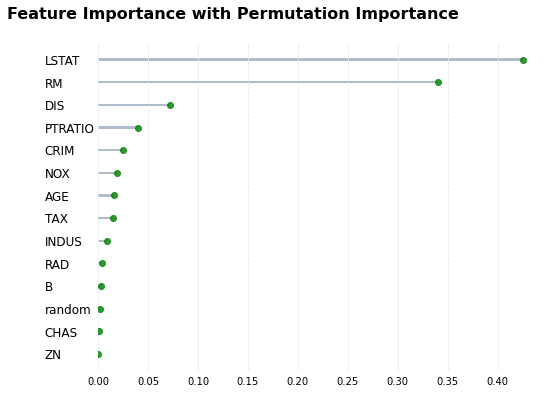

In [13]:
cols_pi, feat_pi_sorted = my_sort(X.columns, feat_pi)
my_plt(feat_pi_sorted, cols_pi,"Feature Importance with Permutation Importance", -.091)

- This graph is showing us how much the metric changed by permuting the values of a feature (one feature at a time).
- As we can see again random came last (one of the last ones) compared to all of the other features. This shows that shuffling bunch of random numbers has no effect on the score of our model. The difference between baseline and the score of permutation is almost 0.

### drop column importance

This method is fairly simple as well. In this method we train the model on the full data (including all the columns) then get a baseline metric. After that we drop one feature at a time, train the model without that feature and then compare the new metric with the baseline. We also need to make sure after each time dropping we should add the column back after we train the model without that column.

#### Pros
1. This algorithm is also easy to implement and understand (same as permutation importance).
2. Works for all the ML models.
3. It gives us information about features that might be effecting our model negatively (making the model worse).

#### Cons
1. It gives very low importance to features that are codependent and share importance.
2. This method computationally is very expensive since we need to train the model p times (p is the number of features in the dataset).

In [14]:
feat_di = dropcol_importances(RandomForestRegressor, X, y)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

Let's observe the result of our feature importance using drop column importance.

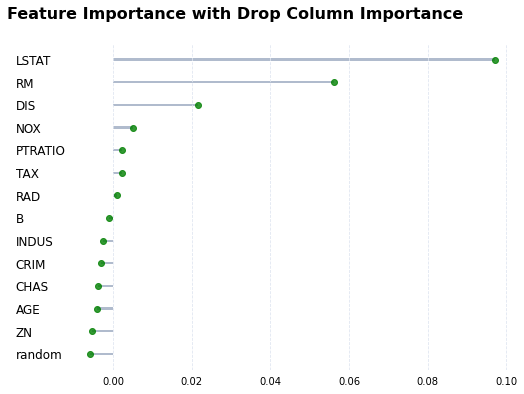

In [16]:
cols_di, feat_di_sorted = my_sort(X.columns, feat_di)
my_plt(feat_di_sorted, cols_di,"Feature Importance with Drop Column Importance", -0.027)

As we can see here the columns random, AGE, INDUS, CHAS, B, CRIM, and ZN actually have negative values which means that we are better off dropping those 7 columns.

### Shap (SHapley Additive exPlanations)

- Shap method is based on game theory. So it uses game theory to explain the output of machine learning model. 
- Shap is explaines the prediction of an instance by computing the contribution of each feature.

In [17]:
model = RandomForestRegressor(n_estimators = 40, random_state = 20).fit(X,y)
explainer = shap.Explainer(model)
shap_values = explainer(X)

Visualizing the result with Shap's built in plot.

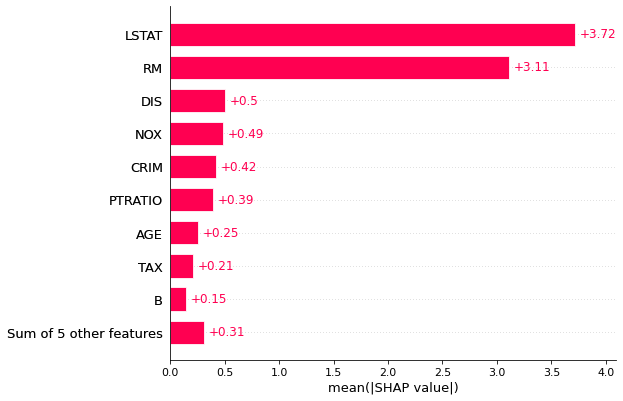

In [18]:
shap.plots.bar(shap_values)

Visualizing the result with my own plot function.

In [19]:
feat_shap = np.mean(np.abs(shap_values.values), axis=0)

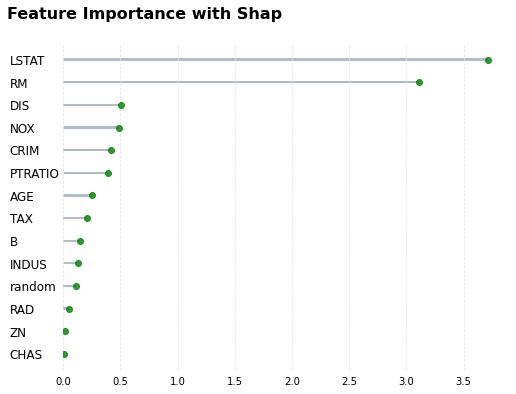

In [21]:
cols_shap, feat_shap_sorted = my_sort(X.columns, feat_shap)
my_plt(feat_shap_sorted, cols_shap,"Feature Importance with Shap", -0.49)

### Comparing Strategies

Now we would like to compare all of the methods with each other. So, we fit the same random forest model on our top k=1,2,..,p from each of our methods. After each time running the model we store our loss (MSE) so later we can compare the results of each method. We need to run the compare methods 5 times in order to get the k mse for each method.

In [22]:
k = 5

In [23]:
mse_spear = compare_methods(k, RandomForestRegressor, X, y, cols_spear)
mse_pca = compare_methods(k, RandomForestRegressor, X, y, cols_pca)
mse_pi = compare_methods(k, RandomForestRegressor, X, y, cols_pi)
mse_di = compare_methods(k, RandomForestRegressor, X, y, cols_di)
mse_shap = compare_methods(k, RandomForestRegressor, X, y, cols_shap)

Let's visualize the performance of each feature importance method.

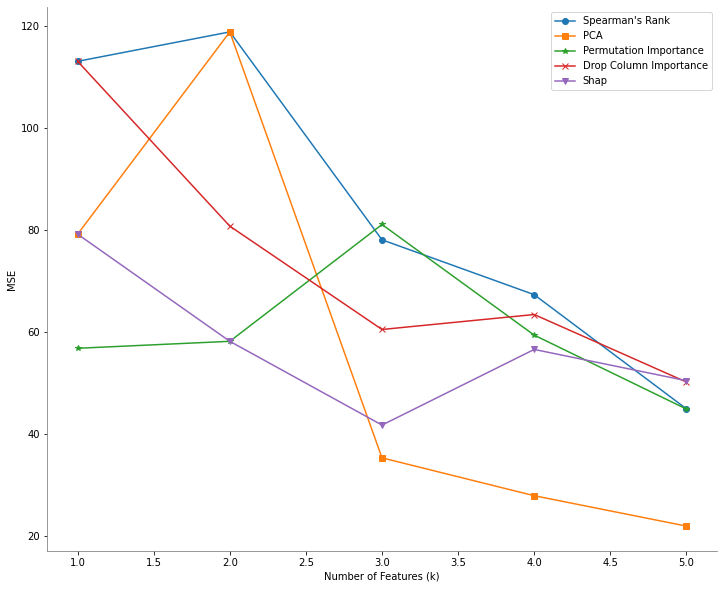

In [24]:
comp_method_plot(k,mse_spear, mse_pca, mse_pi, mse_di, mse_shap)

PCA seems to be doing the best job as it's able to give us the smallest MSE at k=5.

### Automatic Feature Selection Algorithm

In here we are writing an algorithm that selects k best features for our model using drop column importance method. Here is the process of how this algorithm works:
1. First we find the importance of each feature using the drop column importance function we wrote above. We also train our model on the whole data to get a baseline loss value.
2. Then we drop the feature with the worst score from our drop column function.
3. We again train the model but now only on the remaining features and get the new loss value.
4. Continue process 2 and 3 until new loss is worse than loss and there are no more features left with negative drop column importance values.
5. Note: The reason we drop until there are no more negative values is because features with negative drop column values are actually hurting our model.


In [25]:
dropped = feat_selection(RandomForestRegressor, X, y)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

Let's have a look at the result of our algorithm:

In [26]:
print("These are the features that were dropped:",dropped)

These are the features that were dropped: ['random', 'AGE', 'RAD']


### Variance and empirical p-values for feature importances

#### Variance

By using the technique of bootstrapping we can get several results for feature importance which would allow us to calculate standard deviation of the feature importances. So now here we will write a function to give us the standard deviation.

In [27]:
st_devs = my_standard_dev(300,RandomForestRegressor, X, y)

In [28]:
st_dev_sorte, _ = my_sort(list(st_devs.values()), feat_pi)

Let's visualize the error on a bar plot for each feature.

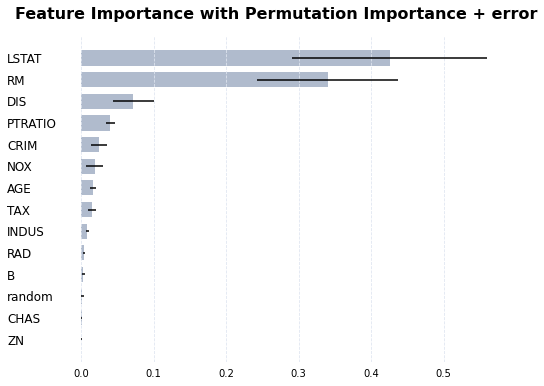

In [29]:
my_plt(feat_pi_sorted, cols_pi,"Feature Importance with Permutation Importance + error", -.091, st_dev=st_dev_sorte, err = True)

#### Empirical p-values

P-value will help us understand if the feature importance we found is actually significant or insignificant. In other words, we can find out if the feature importance we found was by random or if it is actually valud. We will do that by calling the method on random target values and then compare against our baseline feature importances (ran on real target values). We count how many times a feature importance is as important or more important the true feature importance (baseline). If the proportion we get is more than 0.05 then that feature importance is not significant.

Now here we will calculate the p-value for each feature importance to see whether that feature importance is significant or not.

The process of calculating the p-value:
1. We first get a baseline feature importance value using permuation importance as our method.
2. Next we shuffle the target values
3. Then calculate the feature importances with the shuffled data.
4. Repeat process 2 and 3 n times.
5. We have to make sure n is big enough so we have enough observation to be able to have a solid hypothesis.

In [30]:
sample, null, p_values = p_val(300, RandomForestRegressor, X, y)

Let's have a look at the distribution for LSTAT significance.

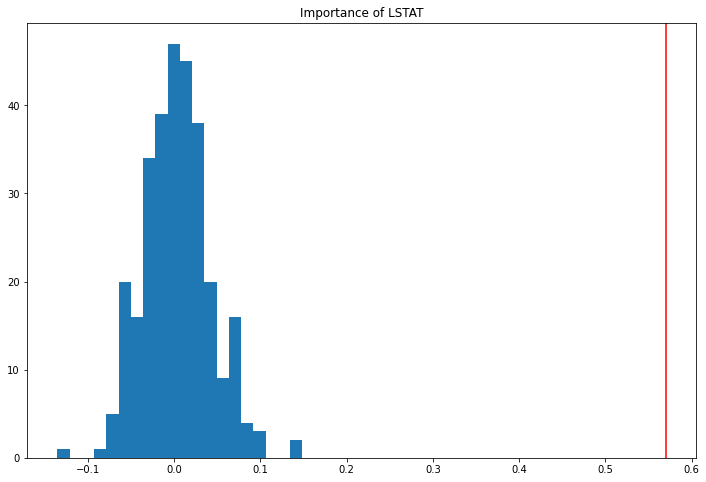

In [31]:
my_hist(sample['LSTAT'], null['LSTAT'], 'Importance of LSTAT')

In [37]:
print('p-value for feature LSTAT is:', p_values['LSTAT']*2)

p-value for feature LSTAT is: 0.0


Having p-value as 0 means that this feature is significant since 0 < 0.05.

Let's have a look at the distribution for random's significance.

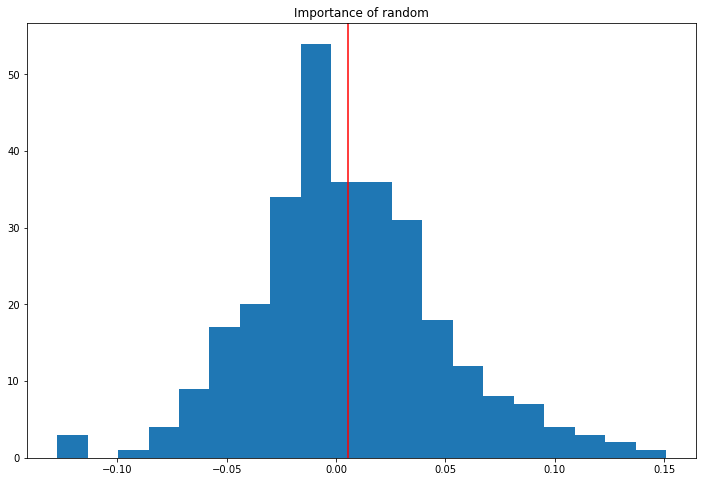

In [38]:
my_hist(sample['random'], null['random'], 'Importance of random')

In [39]:
print('p-value for feature random is:', p_values['random']*2)

p-value for feature random is: 0.9066666666666666


Having p-value bigger than 0.05 (by a lot) means that this feature is insignificant as expected.

Let's have a look at the distribution for RM's significance.

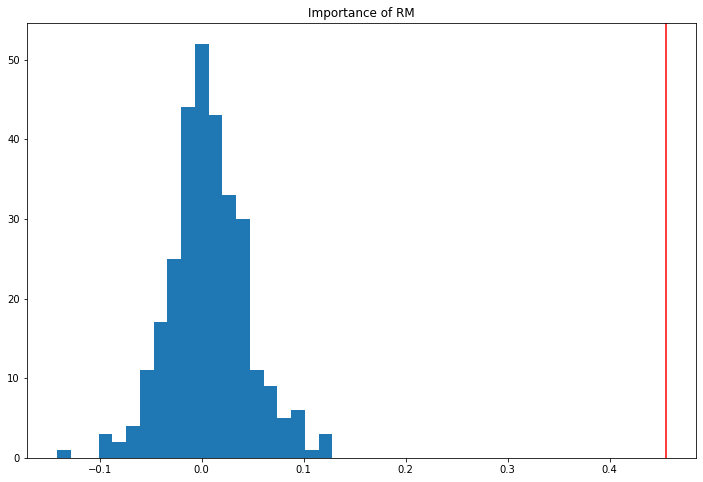

In [40]:
my_hist(sample['RM'], null['RM'], 'Importance of RM')

In [41]:
print('p-value for feature LSTAT is:', p_values['RM']*2)

p-value for feature LSTAT is: 0.0


Having p-value as 0 means that this feature is significant since 0 < 0.05.